In [ ]:
import numpy
from helpers import load_csv_data
import matplotlib.pyplot as plt

# Import the filtering functions
from nan_filtering import nan_feature_filter, nan_datapoint_filter

x_train, x_test, y_train, train_ids, test_ids = load_csv_data(
    "data/dataset/")

Original x_train shape: (328135, 321)
Filtered x_train shape: (328135, 143)
Number of features removed: 178


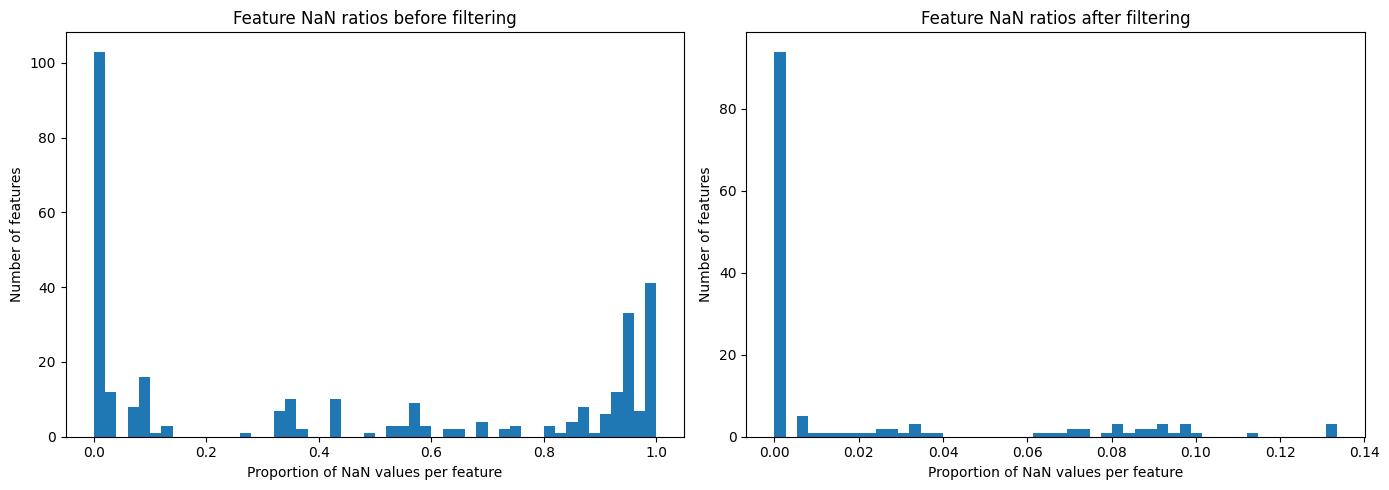

In [ ]:
# Apply feature filtering (remove features with >=80% NaNs)
x_train_filtered, feature_mask = nan_feature_filter(x_train, cutoff_ratio=0.2)
x_test_filtered = x_test[:, feature_mask]  # Apply same mask to test set

print(f"Original x_train shape: {x_train.shape}")
print(f"Filtered x_train shape: {x_train_filtered.shape}")
print(f"Number of features removed: {(~feature_mask).sum()}")

# Plot histogram of feature NaN ratios before and after filtering
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before filtering
nan_ratios_before = numpy.mean(numpy.isnan(x_train), axis=0)
axes[0].hist(nan_ratios_before, bins=50)
axes[0].set_xlabel('Proportion of NaN values per feature')
axes[0].set_ylabel('Number of features')
axes[0].set_title('Feature NaN ratios before filtering')

# After filtering
nan_ratios_after = numpy.mean(numpy.isnan(x_train_filtered), axis=0)
axes[1].hist(nan_ratios_after, bins=50)
axes[1].set_xlabel('Proportion of NaN values per feature')
axes[1].set_ylabel('Number of features')
axes[1].set_title('Feature NaN ratios after filtering')

plt.tight_layout()
plt.show()

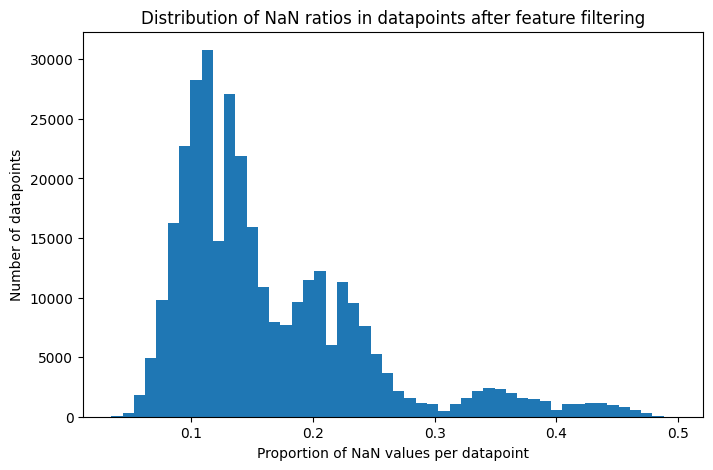

In [ ]:
# Apply datapoint filtering (remove datapoints with >=80% NaNs)
x_train_final, datapoint_mask = nan_datapoint_filter(x_train_filtered, cutoff_ratio=0.2)
y_train_final = y_train[datapoint_mask]  # Filter labels accordingly

print(f"Final x_train shape after datapoint filtering: {x_train_final.shape}")
print(f"Final y_train shape: {y_train_final.shape}")
print(f"Number of datapoints removed: {(~datapoint_mask).sum()}")

# Plot histogram of datapoint NaN ratios after feature filtering
nan_ratios = numpy.mean(numpy.isnan(x_train_filtered), axis=1)
plt.figure(figsize=(8, 5))
plt.hist(nan_ratios, bins=50)
plt.xlabel('Proportion of NaN values per datapoint')
plt.ylabel('Number of datapoints')
plt.title('Distribution of NaN ratios in datapoints after feature filtering')
plt.show()

In [ ]:
# --- Complete preprocessing: load, filter, split, impute, recombine ---
import h5py
import numpy as np
from nan_filtering import nan_feature_filter, nan_datapoint_filter
from is_categorical_or_continuous import is_categorical
from mean_mode_imputation import impute_train_test

with h5py.File("data/dataset/cached_data.h5", "r") as f:
    x_train = f["x_train"][:]
    x_test = f["x_test"][:]
    y_train = f["y_train"][:]
    train_ids = f["train_ids"][:]
    test_ids = f["test_ids"][:]

[328135 328136 328137 ... 437511 437512 437513]


In [ ]:
# Step 1: Feature filtering (remove features with >=80% NaNs)
x_train_filtered, feature_mask = nan_feature_filter(x_train, cutoff_ratio=0.2)
x_test_filtered = x_test[:, feature_mask]  # Apply same mask to test set

# If we want to also filter datapoints with many NaNs, uncomment below:
# x_train_filtered, datapoint_mask = nan_datapoint_filter(x_train_filtered, cutoff_ratio=0.2)
# y_train = y_train[datapoint_mask]

# Step 2: Split into continuous and categorical columns
continuous_mask, categorical_mask = is_categorical(x_train.shape[1], feature_mask)
x_train_cont = x_train_filtered[:, continuous_mask]
x_test_cont = x_test_filtered[:, continuous_mask]
x_train_cat = x_train_filtered[:, categorical_mask]
x_test_cat = x_test_filtered[:, categorical_mask]

# Step 3: Impute missing values (mean for continuous, mode for categorical)
(x_train_cont_imp, x_test_cont_imp,
 x_train_cat_imp, x_test_cat_imp,
 means, modes) = impute_train_test(x_train_cont, x_test_cont, x_train_cat, x_test_cat)

# Step 4: Combine imputed columns back together
x_train_final = np.empty_like(x_train_filtered)
x_test_final = np.empty_like(x_test_filtered)
x_train_final[:, continuous_mask] = x_train_cont_imp
x_train_final[:, categorical_mask] = x_train_cat_imp
x_test_final[:, continuous_mask] = x_test_cont_imp
x_test_final[:, categorical_mask] = x_test_cat_imp

# x_train_final and x_test_final now have NO NaNs
print(f"Any NaNs left in x_train_final? {np.isnan(x_train_final).any()}")
print(f"Any NaNs left in x_test_final? {np.isnan(x_test_final).any()}")

Any NaNs left in x_train_final? False
Any NaNs left in x_test_final? False


In [2]:
from preprocessing_subroutine import preprocess_data

_ = preprocess_data()

preprocess_data: start
preprocess_data: loaded cached data from data/dataset\cached_data.npz
preprocess_data: replaced weird values (train shape (328135, 322), test shape (109379, 322))
preprocess_data: suppressed features -> kept 275/322 features
preprocess_data: nan feature filter -> kept 116/322 original features
preprocess_data: split cont/cat -> cont 43, cat 73 (relative to filtered features)
preprocess_data: one-hot encoded categorical -> train enc shape (328135, 190), test enc shape (109379, 190)
preprocess_data: categorical vocabs (train) -> [2, 3, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3, 2, 8, 7, 2, 8, 2, 5, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 3, 3, 2, 2, 4, 2, 3, 3, 4, 2, 2, 2]
preprocess_data: categorical features with vocab size>2 (original indices -> vocab_size): [(32, 3), (35, 4), (49, 4), (52, 6), (234, 3), (238, 3), (240, 8), (241, 7), (243, 8), (245, 5), (246, 5), (283, 3), (284, 3), (308, 3

In [10]:
import numpy as np
import os

cache_dir = "data/dataset"
cache_path = os.path.join(cache_dir, "cached_data.npz")

with np.load(cache_path) as data:
            x_train = data["x_train"]
            x_test = data["x_test"]
            y_train = data["y_train"]
            train_ids = data["train_ids"]
            test_ids = data["test_ids"]
x_train = np.hstack((np.empty((x_train.shape[0], 1)), x_train))
print(f"preprocess_data: loaded cached data from {cache_path}", flush=True)

preprocess_data: loaded cached data from data/dataset\cached_data.npz


In [32]:
feature = 315

with open("test.csv", "r") as f:
    header_line = f.readline().strip()
    headers = header_line.split(",")
vocab = np.unique(x_train[:, feature])
print(f"Unique values in feature {feature}: {len(vocab)}")
print(x_train[0:50, feature])
headers[feature]

Unique values in feature 315: 5
[3. 3. 2. 2. 3. 3. 2. 2. 3. 2. 3. 3. 3. 9. 2. 3. 3. 2. 3. 1. 3. 3. 3. 3.
 3. 1. 3. 3. 3. 3. 2. 3. 1. 1. 2. 3. 3. 3. 3. 3. 3. 2. 3. 3. 3. 3. 3. 3.
 3. 3.]


'_LMTWRK1'

In [ ]:
above_5_unique_values = [(1, 53), (52, 6), (220, 1306), (221, 1304), (222, 12), 
                          (223, 5528), (240, 8), (241, 7), (243, 8), (249, 62), 
                          (250, 6), (252, 103), (254, 3524), (263, 35), (265, 236)]

[(245, 5), (246, 5), (274, 5)]
[(35, 4), (38, 4), (49, 4), (255, 4), (312, 4), (316, 4)]
[(32, 3), (54, 3), (234, 3), (238, 3), (248, 3), (273, 3), (283, 3), (284, 3), (308, 3), (309, 3), (314, 3), (315, 3)]

# load headers in test.csv file without pandas
with open("test.csv", "r") as f:
    header_line = f.readline().strip()
    headers = header_line.split(",")
print(len(headers))
print([headers[i] for i, _ in above_5_unique_values])

322
['_STATE', 'MARITAL', '_STSTR', '_STRWT', '_RAWRAKE', '_WT2RAKE', '_PRACE1', '_MRACE1', '_RACE', '_AGE80', '_AGE_G', 'HTM4', '_BMI5', 'DROCDY3_', '_DRNKWEK']
